In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import datetime
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import warnings

from statsmodels.tsa.stattools import adfuller


warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('data/southeast.csv', index_col='index', usecols=['Data', 'Hora','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','index','station'])

In [3]:
data.head(16)

,Data,Hora,"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",station
index,,,,
0,2000-05-07,00:00,-9999.0,ECOLOGIA AGRICOLA
1,2000-05-07,01:00,-9999.0,ECOLOGIA AGRICOLA
2,2000-05-07,02:00,-9999.0,ECOLOGIA AGRICOLA
3,2000-05-07,03:00,-9999.0,ECOLOGIA AGRICOLA
4,2000-05-07,04:00,-9999.0,ECOLOGIA AGRICOLA
5,2000-05-07,05:00,-9999.0,ECOLOGIA AGRICOLA
6,2000-05-07,06:00,-9999.0,ECOLOGIA AGRICOLA
7,2000-05-07,07:00,-9999.0,ECOLOGIA AGRICOLA
8,2000-05-07,08:00,-9999.0,ECOLOGIA AGRICOLA


In [4]:
help(pd.cut)

Help on function cut in module pandas.core.reshape.tile:

cut(x, bins, right: 'bool' = True, labels=None, retbins: 'bool' = False, precision: 'int' = 3, include_lowest: 'bool' = False, duplicates: 'str' = 'raise', ordered: 'bool' = True)
    Bin values into discrete intervals.
    
    Use `cut` when you need to segment and sort data values into bins. This
    function is also useful for going from a continuous variable to a
    categorical variable. For example, `cut` could convert ages to groups of
    age ranges. Supports binning into an equal number of bins, or a
    pre-specified array of bins.
    
    Parameters
    ----------
    x : array-like
        The input array to be binned. Must be 1-dimensional.
    bins : int, sequence of scalars, or IntervalIndex
        The criteria to bin by.
    
        * int : Defines the number of equal-width bins in the range of `x`. The
          range of `x` is extended by .1% on each side to include the minimum
          and maximum values 

In [5]:
def splitDayTime(hour):
    morning = ['01:00','02:00','03:00','04:00','05:00','06:00','07:00']
    day = ['08:00','09:00','10:00','11:00','12:00','13:00']
    afternoon = ['14:00','15:00','16:00','17:00','18:00','19:00']
    night = ['20:00','21:00','22:00','23:00','00:00']
    daytime = ''
    if hour in morning:
        daytime = 'morning'
    elif hour in day:
        daytime = 'day'
    elif hour in afternoon:
        daytime = 'afternoon'
    elif hour in night:
        daytime = 'night'
    return daytime

data['Daytime'] = data['Hora'].map(splitDayTime)
data.head()

,Data,Hora,"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",station,Daytime
index,,,,,
0,2000-05-07,00:00,-9999.0,ECOLOGIA AGRICOLA,night
1,2000-05-07,01:00,-9999.0,ECOLOGIA AGRICOLA,morning
2,2000-05-07,02:00,-9999.0,ECOLOGIA AGRICOLA,morning
3,2000-05-07,03:00,-9999.0,ECOLOGIA AGRICOLA,morning
4,2000-05-07,04:00,-9999.0,ECOLOGIA AGRICOLA,morning


In [6]:
dataAnalyze = data[(data['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)']>=-10)][['Data','Hora','TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)','Daytime','station']].rename({'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)':'Temp'}, axis = 1)
dataAnalyze.head()

,Data,Hora,Temp,Daytime,station
index,,,,,
12,2000-05-07,12:00,22.0,day,ECOLOGIA AGRICOLA
13,2000-05-07,13:00,22.4,day,ECOLOGIA AGRICOLA
14,2000-05-07,14:00,22.6,afternoon,ECOLOGIA AGRICOLA
15,2000-05-07,15:00,22.6,afternoon,ECOLOGIA AGRICOLA
16,2000-05-07,16:00,22.1,afternoon,ECOLOGIA AGRICOLA


In [7]:
dataAnalyze.groupby(['station','Daytime'])['Temp'].mean().sort_values(ascending=False)

station      Daytime  
SAO ROMAO    afternoon    30.673264
MONTALVANIA  afternoon    30.647941
JANUARIA     afternoon    30.611562
JANAUBA      afternoon    30.596533
MOCAMBINHO   afternoon    30.541366
                            ...    
ITATIAIA     morning       8.194276
CRIOSFERA    night        -8.936364
             afternoon    -9.011111
             day          -9.150000
             morning      -9.550000
Name: Temp, Length: 640, dtype: float64

In [8]:
dataBauru = dataAnalyze[dataAnalyze['station'] == 'BAURU']
def funConcatTime(data,hora):
    s = data + ' ' + hora
    return s
dataBauru.loc[:,'DataHora']= 0
dataBauru.loc[:,'DataHora'] = dataBauru.apply(lambda x: funConcatTime(x.Data, x.Hora), axis = 1)
dataBauru.loc[:,'DataHora'] = pd.to_datetime(dataBauru['DataHora'])
dataBauru = dataBauru[(dataBauru['DataHora'].dt.year>2007)]
dataBauru.drop(['Data','Hora'], axis = 1, inplace=True)

In [9]:
dataBauru.set_index('DataHora', inplace=True)

In [10]:
dataBauru.head()

,Temp,Daytime,station
DataHora,,,
2008-01-01 00:00:00,25.2,night,BAURU
2008-01-01 01:00:00,24.8,morning,BAURU
2008-01-01 02:00:00,23.3,morning,BAURU
2008-01-01 03:00:00,23.2,morning,BAURU
2008-01-01 04:00:00,20.7,morning,BAURU


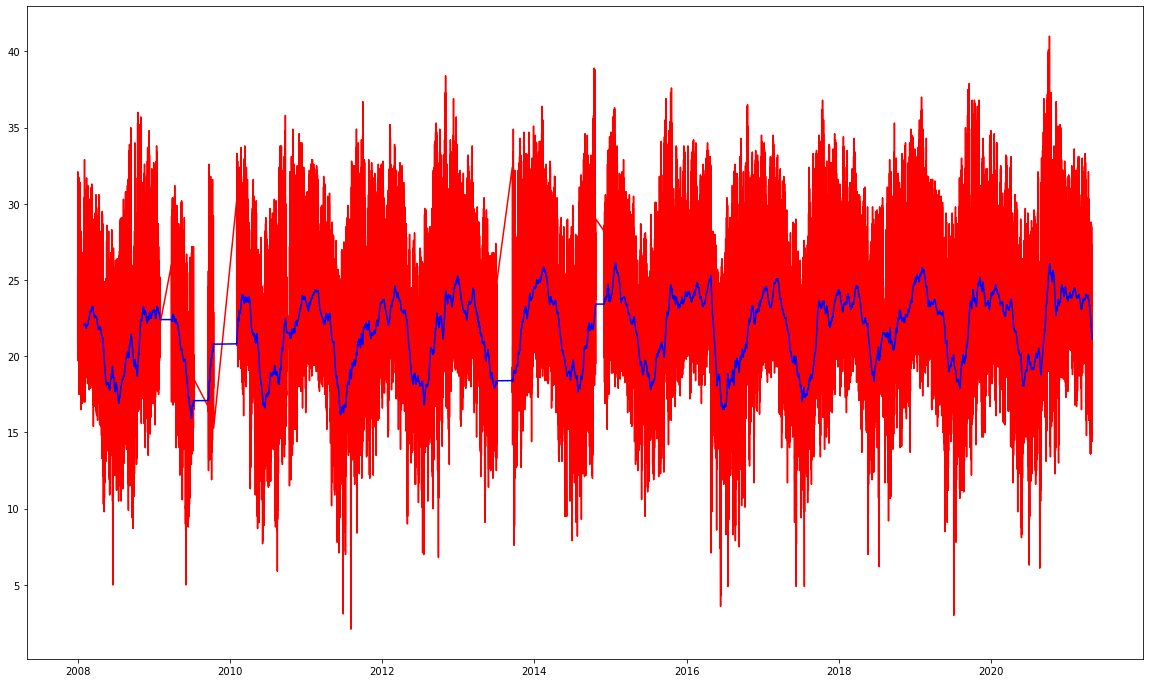

In [11]:
plt.figure(figsize = (20,12))
plt.plot(dataBauru['Temp'], color = 'r')
plt.plot(dataBauru['Temp'].rolling(720).mean(), color ='b')
plt.show()

In [12]:
dataBauru.reset_index(inplace=True)
dataBauru.rename({'DataHora':'ds','Temp':'y'}, axis = 1, inplace=True)
dataBauru.head()

,ds,y,Daytime,station
0,2008-01-01 00:00:00,25.2,night,BAURU
1,2008-01-01 01:00:00,24.8,morning,BAURU
2,2008-01-01 02:00:00,23.3,morning,BAURU
3,2008-01-01 03:00:00,23.2,morning,BAURU
4,2008-01-01 04:00:00,20.7,morning,BAURU


In [13]:
result = adfuller(dataBauru['y'].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -16.670876
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


In [14]:
dataBauru['Year'] = dataBauru['ds'].dt.year

In [15]:
dataBauru.dtypes

ds         datetime64[ns]
y                 float64
Daytime            object
station            object
Year                int64
dtype: object

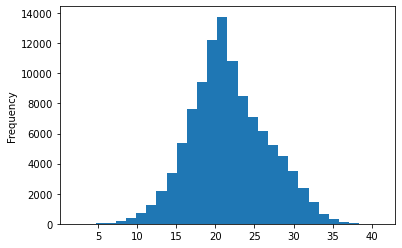

In [16]:
dataBauru['y'].plot.hist(bins = 30);

In [17]:
train = dataBauru[(dataBauru['Year'] <= 2019) & (dataBauru['Year']>=2007)]
test = dataBauru[dataBauru['Year'] == 2020]

In [18]:
train.shape, test.shape

((95751, 5), (8784, 5))

In [19]:
preditor = Prophet()
preditor.fit(train)

14:30:33 - cmdstanpy - INFO - Chain [1] start processing
14:31:19 - cmdstanpy - INFO - Chain [1] done processing


In [20]:
pred = preditor.predict(test)

In [21]:
pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-01 00:00:00,22.698199,20.300570,27.818216,22.698199,22.698199,1.313816,1.313816,1.313816,-1.181848,...,-0.023940,-0.023940,-0.023940,2.519604,2.519604,2.519604,0.0,0.0,0.0,24.012014
1,2020-01-01 01:00:00,22.698244,20.232278,27.391758,22.698244,22.698244,0.988578,0.988578,0.988578,-1.504945,...,-0.025146,-0.025146,-0.025146,2.518669,2.518669,2.518669,0.0,0.0,0.0,23.686822
2,2020-01-01 02:00:00,22.698289,19.841042,27.133779,22.698289,22.698289,0.561666,0.561666,0.561666,-1.929593,...,-0.026462,-0.026462,-0.026462,2.517721,2.517721,2.517721,0.0,0.0,0.0,23.259954
3,2020-01-01 03:00:00,22.698334,18.802859,26.532288,22.698334,22.698334,0.028970,0.028970,0.028970,-2.459914,...,-0.027876,-0.027876,-0.027876,2.516760,2.516760,2.516760,0.0,0.0,0.0,22.727304
4,2020-01-01 04:00:00,22.698379,18.774512,26.225567,22.698379,22.698379,-0.430244,-0.430244,-0.430244,-2.916662,...,-0.029368,-0.029368,-0.029368,2.515787,2.515787,2.515787,0.0,0.0,0.0,22.268135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,2020-12-31 19:00:00,23.093663,26.916521,34.680192,21.934892,24.254827,7.689252,7.689252,7.689252,5.087221,...,0.095574,0.095574,0.095574,2.506458,2.506458,2.506458,0.0,0.0,0.0,30.782916
8780,2020-12-31 20:00:00,23.093709,25.439372,33.309030,21.934588,24.255052,6.294155,6.294155,6.294155,3.686809,...,0.101987,0.101987,0.101987,2.505359,2.505359,2.505359,0.0,0.0,0.0,29.387864
8781,2020-12-31 21:00:00,23.093754,23.732712,31.302718,21.934285,24.255276,4.521457,4.521457,4.521457,1.909257,...,0.107953,0.107953,0.107953,2.504248,2.504248,2.504248,0.0,0.0,0.0,27.615211
8782,2020-12-31 22:00:00,23.093799,22.353031,29.827802,21.933982,24.255501,2.946566,2.946566,2.946566,0.330032,...,0.113410,0.113410,0.113410,2.503124,2.503124,2.503124,0.0,0.0,0.0,26.040365


In [22]:
mae = mean_absolute_error(test['y'], pred['yhat'])
rmse = np.sqrt(mean_squared_error(test['y'], pred['yhat']))
mape = mean_absolute_percentage_error(test['y'], pred['yhat'])
mae, rmse, mape

(2.496289611555087, 3.263397494761554, 0.12581717505833268)

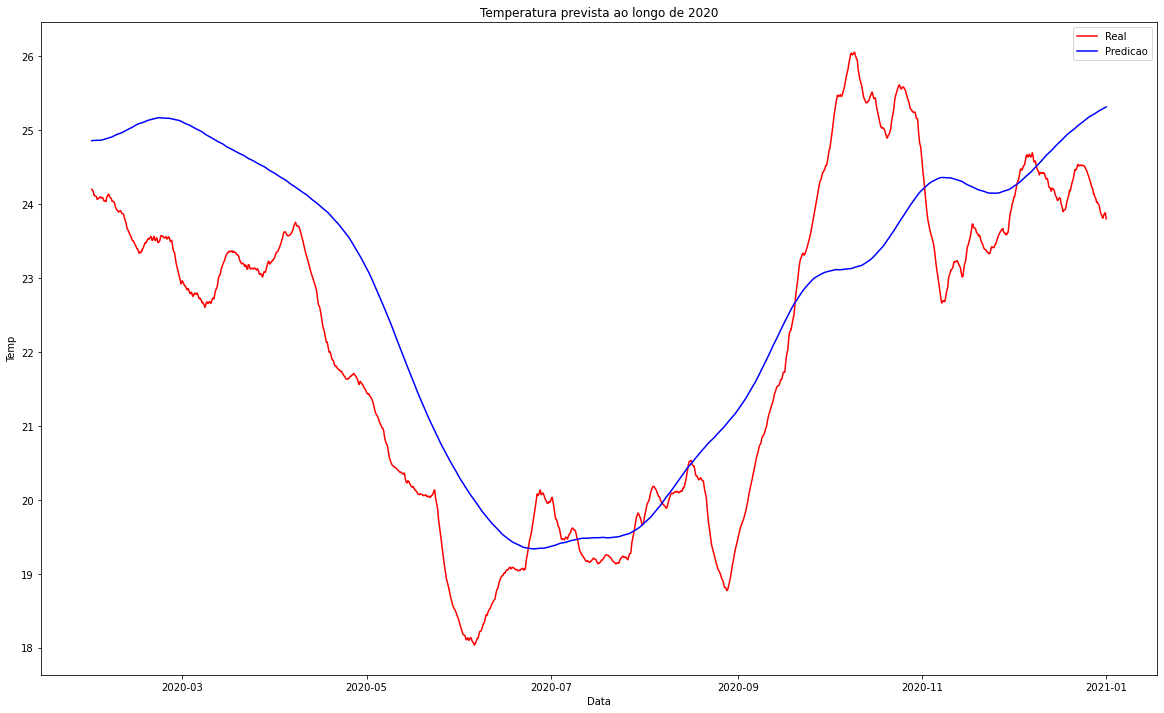

In [23]:
plt.figure(figsize=(20,12))
plt.plot(test.set_index('ds')['y'].rolling(720).mean(), color = 'r', label = 'Real')
plt.plot(pred.set_index('ds')['yhat'].rolling(720).mean(), color = 'b', label = 'Predicao')
plt.legend()
plt.ylabel('Temp')
plt.xlabel('Data')
plt.title('Temperatura prevista ao longo de 2020')
plt.show()

In [24]:
?Prophet.make_future_dataframe

Signature:
Prophet.make_future_dataframe(
    self,
    periods,
    freq='D',
    include_history=True,
)
Docstring:
Simulate the trend using the extrapolated generative model.

Parameters
----------
periods: Int number of periods to forecast forward.
freq: Any valid frequency for pd.date_range, such as 'D' or 'M'.
include_history: Boolean to include the historical dates in the data
    frame for predictions.

Returns
-------
pd.Dataframe that extends forward from the end of self.history for the
requested number of periods.
File:      ~/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py
Type:      function


In [25]:
futureDF = preditor.make_future_dataframe(periods=24*30*24, freq='H', include_history=True)
futureDF.tail()

,ds
113026,2021-12-20 19:00:00
113027,2021-12-20 20:00:00
113028,2021-12-20 21:00:00
113029,2021-12-20 22:00:00
113030,2021-12-20 23:00:00


In [26]:
predFuture = preditor.predict(futureDF)

In [27]:
predFuture

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2008-01-01 00:00:00,20.398576,18.056349,25.325014,20.398576,20.398576,1.325438,1.325438,1.325438,-1.181848,...,-0.012318,-0.012318,-0.012318,2.519604,2.519604,2.519604,0.0,0.0,0.0,21.724015
1,2008-01-01 01:00:00,20.398720,17.602513,25.066707,20.398720,20.398720,1.000099,1.000099,1.000099,-1.504945,...,-0.013625,-0.013625,-0.013625,2.518669,2.518669,2.518669,0.0,0.0,0.0,21.398819
2,2008-01-01 02:00:00,20.398863,17.279034,24.561099,20.398863,20.398863,0.573375,0.573375,0.573375,-1.929593,...,-0.014753,-0.014753,-0.014753,2.517721,2.517721,2.517721,0.0,0.0,0.0,20.972238
3,2008-01-01 03:00:00,20.399007,16.931083,24.208830,20.399007,20.399007,0.041138,0.041138,0.041138,-2.459914,...,-0.015708,-0.015708,-0.015708,2.516760,2.516760,2.516760,0.0,0.0,0.0,20.440145
4,2008-01-01 04:00:00,20.399150,16.433017,23.834288,20.399150,20.399150,-0.417371,-0.417371,-0.417371,-2.916662,...,-0.016495,-0.016495,-0.016495,2.515787,2.515787,2.515787,0.0,0.0,0.0,19.981779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113026,2021-12-20 19:00:00,23.476380,26.070737,36.146082,20.076175,27.037414,7.447043,7.447043,7.447043,5.087221,...,-0.003244,-0.003244,-0.003244,2.363066,2.363066,2.363066,0.0,0.0,0.0,30.923423
113027,2021-12-20 20:00:00,23.476425,24.410936,34.215215,20.075721,27.037713,6.046180,6.046180,6.046180,3.686809,...,-0.005366,-0.005366,-0.005366,2.364737,2.364737,2.364737,0.0,0.0,0.0,29.522605
113028,2021-12-20 21:00:00,23.476470,22.523028,32.746476,20.075268,27.038012,4.268314,4.268314,4.268314,1.909257,...,-0.007348,-0.007348,-0.007348,2.366405,2.366405,2.366405,0.0,0.0,0.0,27.744785
113029,2021-12-20 22:00:00,23.476515,20.631980,31.272430,20.074815,27.038311,2.688929,2.688929,2.688929,0.330032,...,-0.009174,-0.009174,-0.009174,2.368071,2.368071,2.368071,0.0,0.0,0.0,26.165444


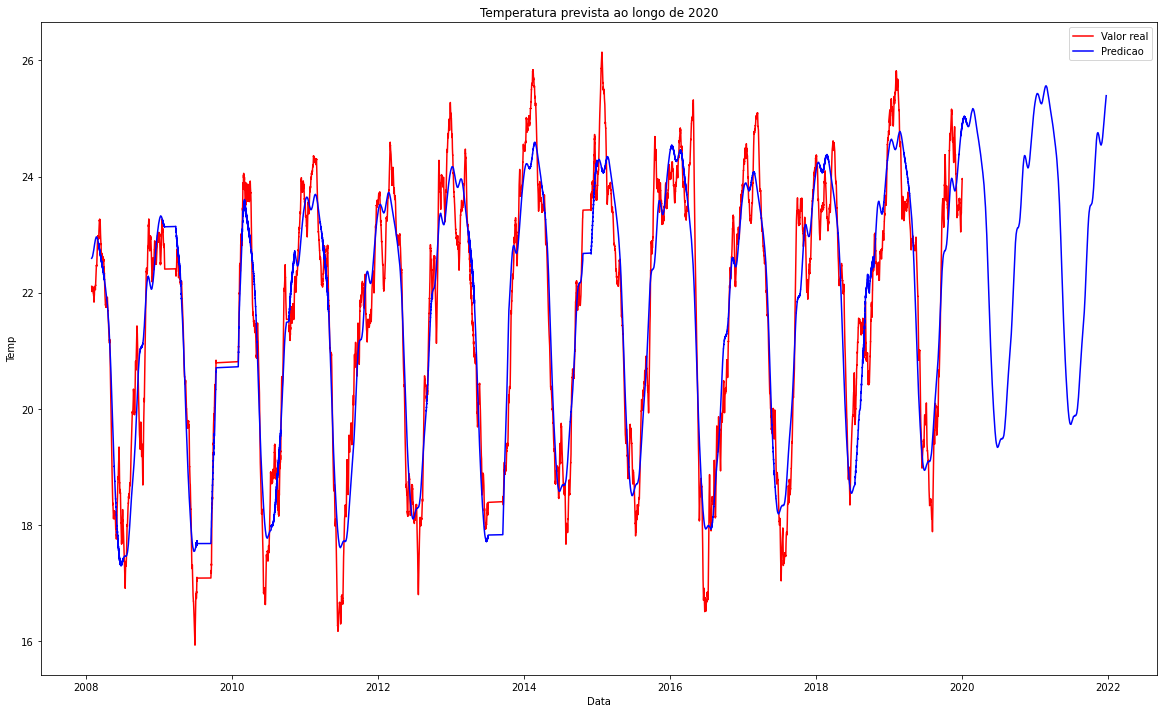

In [28]:
plt.figure(figsize=(20,12))
plt.plot(train.set_index('ds')['y'].rolling(720).mean(), color = 'r', label = 'Valor real')
plt.plot(predFuture.set_index('ds')['yhat'].rolling(720).mean(), color = 'b', label = 'Predicao')
plt.legend()
plt.ylabel('Temp')
plt.xlabel('Data')
plt.title('Temperatura prevista ao longo de 2020')
plt.show()

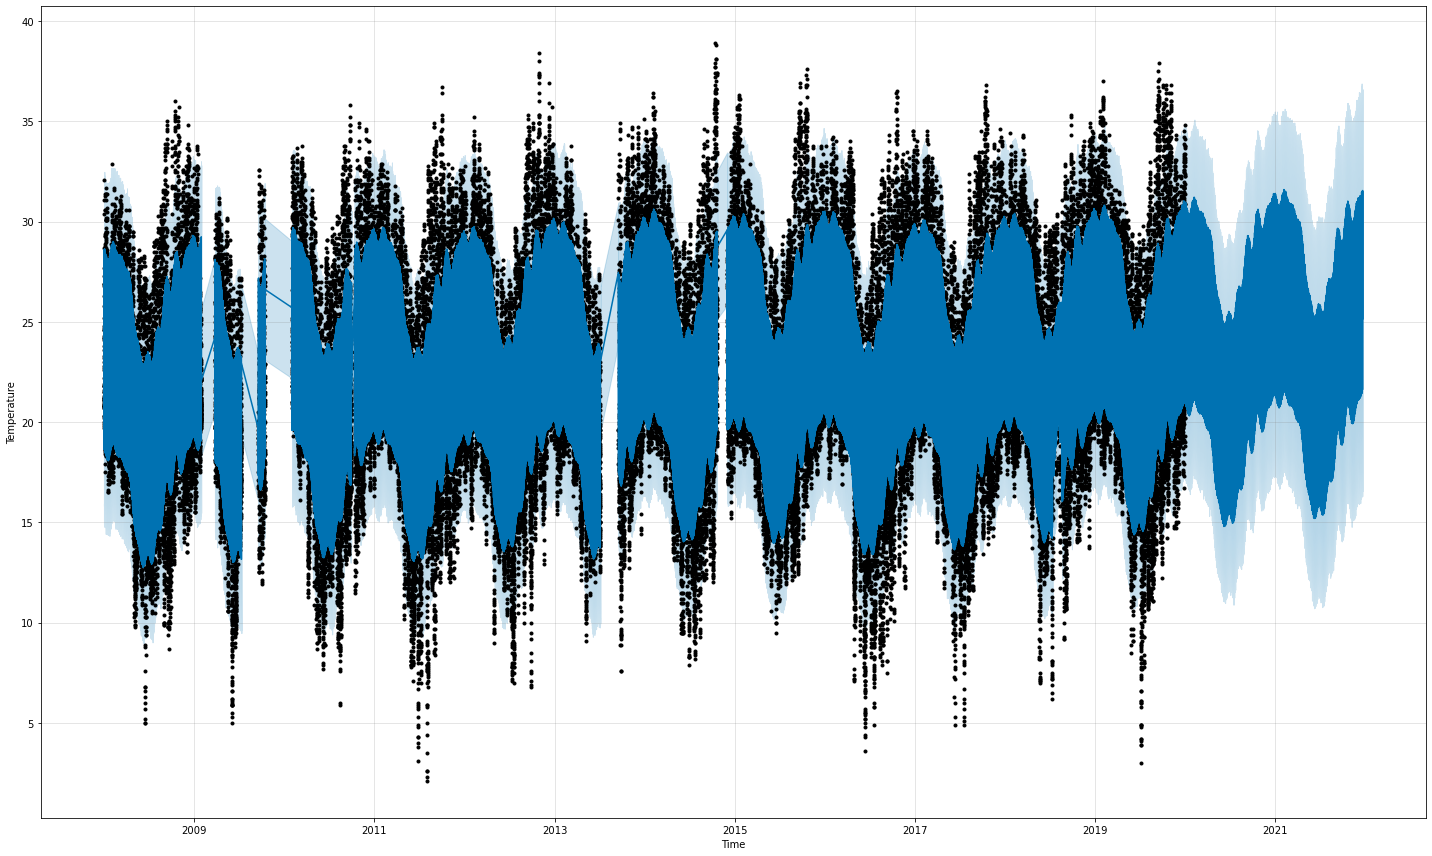

In [29]:
preditor.plot(predFuture, uncertainty=True, xlabel = 'Time', ylabel = 'Temperature',figsize = (20,12));

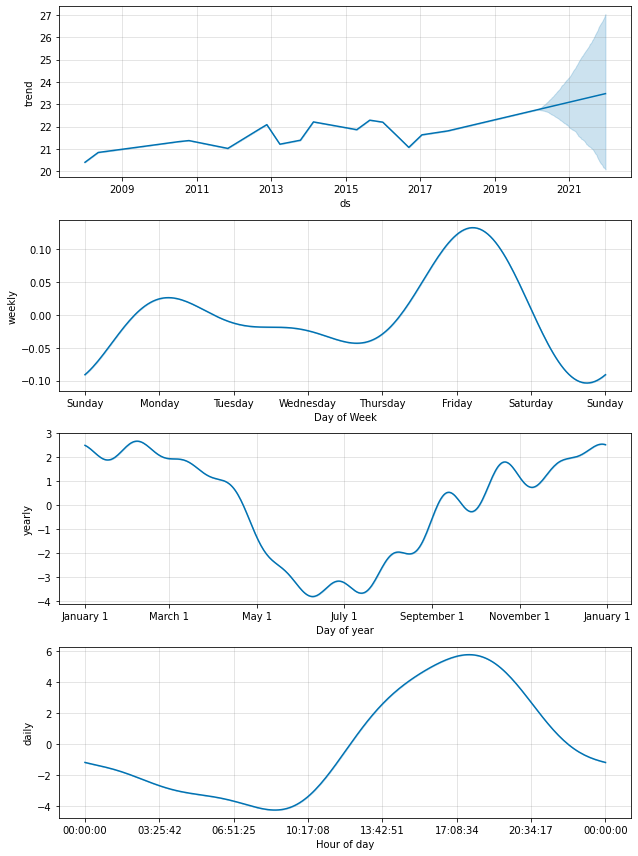

In [30]:
preditor.plot_components(predFuture);